# Estimate the kappa FFT for a cluster

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 

import lensit as li
from lensit.clusterlens import lensingmap 
from lensit.ffs_covs import ffs_cov, ell_mat

import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.interpolate import UnivariateSpline as spline



***could not import bicubic fortran module
***I wont be able to lens maps or invert a deflection field


In [2]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [3]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname(camb.__path__[0]),  'inifiles', cambinifile + '.ini'))
# pars.set_for_lmax(20000)
# pars.set_accuracy(2)
results = camb.get_results(pars)


In [23]:
# We define here the parameters for the profile of the cluster
M200 = 1e14
z = 1
profname = 'nfw'
profparams={'M200c':M200, 'z':z}

# Define here the map square patches
npix = 128  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 70000 

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 3000


# Number of simulated maps 
nsims = 100

# Set CMB experiment for noise level and beam
cmb_exp='S4_opti'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile, profname, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
print(libdir)

/Users/louis/Code/LensIt/lensit_write/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_opti/nfw_profile/npix128_lpix_0.3amin_lmaxsky70000/M200_1.000000E+14_z1/100_sims


In [24]:
camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=ellmaxsky).T
cls_len = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3]}
# cpp_true = results.get_lens_potential_cls(CMB_unit='muK', raw_cl=True, lmax=ellmaxsky).T[0]

In [25]:
# Instantiate the class containing the simulated maps 

clustermaps = lensingmap.cluster_maps(libdir, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat, cmb_exp=cmb_exp)


 [00:00:01] Generating CMB phases ---------> 99%
 [00:00:00] Generating Noise phases -> 15%

/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:254: RuntimeWarning: invalid value encountered in true_divide
  dx_lm = 2 * rfft_kappa * 1.j * KX / (KX**2+KY**2)
/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:255: RuntimeWarning: invalid value encountered in true_divide
  dy_lm = 2 * rfft_kappa * 1.j * KY / (KX**2+KY**2)


 [00:00:01] Generating Noise phases ---------> 99%


In [26]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1) ** 2 * 0.25 

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

In [27]:
ellmax_sky = clustermaps.ellmax_sky

lib_skyalm = clustermaps.lib_skyalm


In [28]:
ell, = np.where(lib_skyalm.get_Nell()[:ellmaxsky+1])

kappa_map = clustermaps.get_kappa_map(clustermaps.M200, clustermaps.z)

ckk_map = lib_skyalm.map2cl(kappa_map)
cpp_map_interp = 10**spline(ell, np.log10(ckk_map[ell]))(np.arange(ellmaxsky+1)) * kk_to_pp(np.arange(ellmaxsky+1))


kappa_ell = clustermaps.haloprofile.analitic_kappa_ft(clustermaps.M200, clustermaps.z, np.arange(ellmax_sky+1))
ckk_fid = kappa_ell **2 
cpp_fid = kk_to_pp(np.arange(ellmax_sky+1))*ckk_fid


ckk_alm = lib_skyalm.map2alm(kappa_map)

ckk_bin = lib_skyalm.bin_realpart_inell(ckk_alm)

# cpp_prior = cpp_prior * kk_to_pp(np.arange(isocov.lib_skyalm.ellmax +1))

<ipython-input-28-520869dfc238>:6: RuntimeWarning: divide by zero encountered in log10
  cpp_map_interp = 10**spline(ell, np.log10(ckk_map[ell]))(np.arange(ellmaxsky+1)) * kk_to_pp(np.arange(ellmaxsky+1))
/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:157: RuntimeWarning: invalid value encountered in subtract
  Cidiff = Cixpc - Cix
/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:158: RuntimeWarning: invalid value encountered in true_divide
  u0 = np.sin(x) * Sidiff + np.cos(x) * Cidiff - np.sin(x * c) / (x * (1. + c))


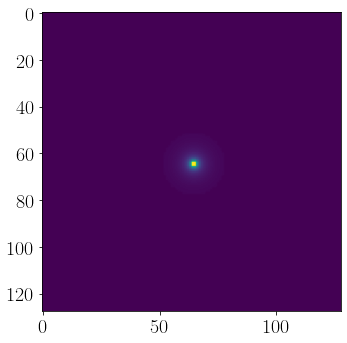

In [29]:
plt.imshow(kappa_map)

In [30]:
# plt.plot(cpp_map_interp[:lib_skyalm.ellmax +1]*pp_to_kk(np.arange(lib_skyalm.ellmax +1)))


# plt.plot(ell, ckk_map[ell])
# # plt.plot(ell, ckk_bin[ell])
# plt.plot(ckk_fid, label='Th. Cl kappa')

# plt.loglog()

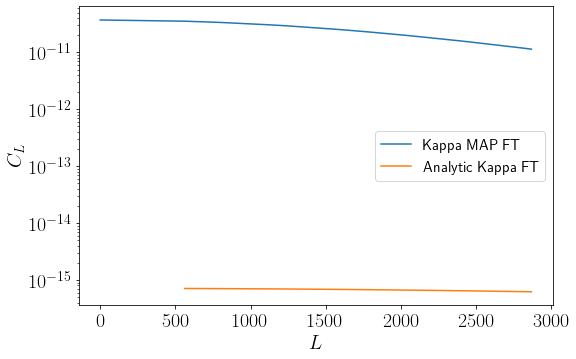

In [33]:

ell, = np.where(lib_skyalm.get_Nell()[:ellmaxdat+1])


plt.plot(ell, ckk_map[ell], label='Kappa MAP FT')
plt.plot(ell, ckk_fid[ell], label='Analytic Kappa FT')
# plt.plot(ell, ckk_bin[ell], label='Analytic Kappa FT')

plt.semilogy()

plt.xlabel(r'$L$')
plt.ylabel(r'$C_L$')

plt.legend()